In [1]:
from imports import *
from exactDiagMethods import perform_exact_diag, build_exact_diag_hamiltonian
from globalMethods import build_initial_states, output_results
from vqteMethods import  hamiltonian_generation, perform_vqte

## Fix VQTE Ham  

## Select 5 cases of diff temps / mus
## Plot each case
## Check out savefig()
## Produce a document to show equality between classical / hybrid

In [ ]:

def main():

    # Initialize the simulation parameters
    gamma_L = 10.01
    gamma_R = 2.0

    eps = 1.0
    mu_L= 0.1
    mu_R= 2.1
    T_L = 10.0
    T_R= 1.0

    time = 5.0
    dt = 0.005
    nt = int(time/dt)

    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

    J = 1
    eps_list = [1]


    exact_diag_ham = build_exact_diag_hamiltonian(J,eps_list)
    ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)
    
    print("The real hamiltonian is ", ham_real.to_matrix())
    print("The imaginary hamiltonian is" , ham_imag.to_matrix())
   
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
   
    print("The vqte init state is" ,vqte_init_state)
    print("The exact diag initial state is ",exact_diag_init_state)


    print("The exact ham is", exact_diag_ham)


    # Perform exact diagonalization
    exact_diag_results, time_points = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)

    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    output_results(vqte_results, exact_diag_results, time, nt, time_points)


    print("Final VQTE: ",vqte_results[-1])
    print("Final exact: ", exact_diag_results[-1])

The real hamiltonian is  [[ 0.+0.j          0.+0.j          0.+0.j          0.-1.02622743j]
 [ 0.+0.j          1.+0.j          0.+0.j          0.+0.j        ]
 [ 0.+0.j          0.+0.j         -1.+0.j          0.+0.j        ]
 [ 0.+1.02622743j  0.+0.j          0.+0.j          0.+0.j        ]]
The imaginary hamiltonian is [[ 8.53122743+0.j  0.        +0.j  0.        +0.j -7.505     +0.j]
 [ 0.        +0.j  7.505     +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  7.505     +0.j  0.        +0.j]
 [-7.505     +0.j  0.        +0.j  0.        +0.j  6.47877257+0.j]]
Is Hermitian: True
Trace: (0.9999999999999997+1.469576158976824e-15j) (should be 1)
Eigenvalues: [-3.6739404e-16  1.0000000e+00]
All eigenvalues ≥ 0: False
Purity (Tr(ρ²)): (1+2.939152317953648e-15j) (should be 1 for pure state)
The vqte init state is Statevector([ 1.00000000e+00+1.46957616e-15j,
             -3.67394040e-16-1.79971174e-31j,
             -7.34788079e-16-4.49927935e-31j,
             -3.67

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


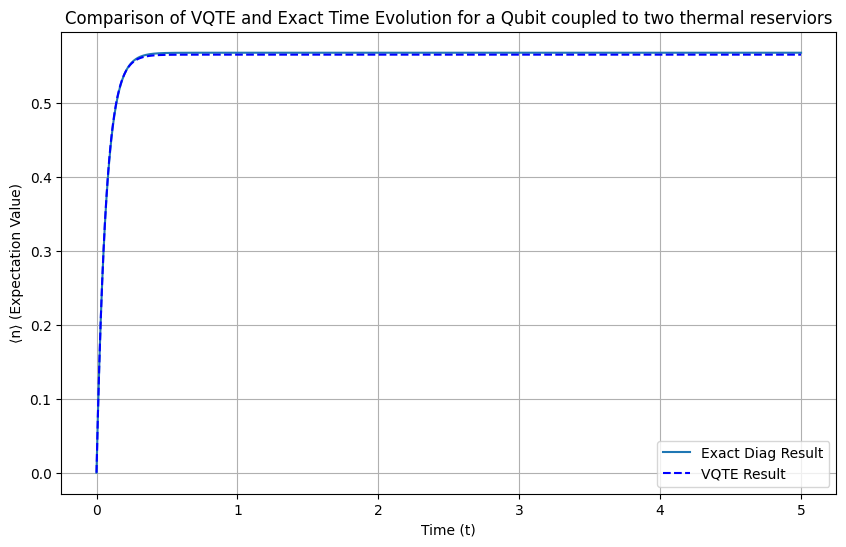

Final VQTE:  0.5657578533861174
Final exact:  (0.5683695823990449+1.972152263052568e-31j)


In [3]:
main()